Reproducing some results from [Chinchilla](https://arxiv.org/pdf/2203.15556.pdf). I can't get the numbers to match exactly, please open an Issue if you understand why the results are off by a bit. Current running hypothesis is that this is because I am using the FLOPs = 6\*N\*D formula, instead of taking all the Gopher sizes and calculating their FLOPs individually, and using that to interpolate?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
gpt2 = dict(
    seq_len = 1024,
    vocab_size = 50257,
    d_model = 768,
    num_heads = 12,
    num_layers = 12,
)

In [3]:
def params(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size=4):
    """ Given GPT config calculate total number of parameters""" 
    # token and position embeddings
    embeddings = d_model * vocab_size + d_model * seq_len
    # transformer blocks
    attention = 3*d_model**2 + 3*d_model # weights and biases
    attproj = d_model**2 + d_model
    ffw = d_model*(ffw_size*d_model) + ffw_size*d_model
    ffwproj = ffw_size*d_model*d_model + d_model
    layernorms = 2*2*d_model
    # dense
    ln_f = 2*d_model
    dense = d_model*vocab_size # note: no bias here
    # note: embeddings are not included in the param count!
    total_params = num_layers*(attention + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    return total_params

params(**gpt2)/1e6 # OpenAI reports gpt2 (small) as having 124M params, good.

123.653376

In [4]:
def flops(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size=4):
    """ 
    Given GPT config calculate total number of FLOPs, see Chinchilla 
    paper Appendix F as reference: https://arxiv.org/pdf/2203.15556.pdf
    """ 
    key_size = d_model // num_heads

    # embeddings
    embeddings = 2 * seq_len * vocab_size * d_model

    # attention
    # key, query, value projections
    attention = 2 * 3 * seq_len * d_model * (key_size * num_heads)
    # key @ query logits
    attlogits = 2 * seq_len * seq_len * (key_size * num_heads)
    # softmax
    attsoftmax = 3 * num_heads * seq_len * seq_len # TODO why?
    # softmax @ value reductions
    attvalue = 2 * seq_len * seq_len * (key_size * num_heads)
    # final linear
    attlinear = 2 * seq_len * (key_size * num_heads) * d_model
    att = attention + attlogits + attsoftmax + attvalue + attlinear
    # feed forward
    dense = 2 * seq_len * (d_model * ffw_size + d_model * ffw_size)

    # logits
    logits = 2 * seq_len * d_model * vocab_size

    forward_flops = embeddings + num_layers * (att + dense) + logits
    backward_flops = 2 * forward_flops # as in Kaplan et al. 2020
    total_flops = forward_flops + backward_flops

    return total_flops

flops(**gpt2)/1e9

766.006788096

In [5]:
# Reproduce Table A4 from Chinchilla paper Appendix, 
# comparing accurate flops above to approximate flops F = 6*N*D
# note Chinchilla uses vocab_size = 32K

chin_73M = dict(seq_len = 1024, vocab_size = 32000, d_model = 640, num_heads = 10, num_layers = 10)
args = chin_73M

D = 1024 # dataset size, cancels anyway
N = params(**args) 
F = flops(**args)

approx_flops = 6*D*N
chinch_flops = F * (float(D) / args['seq_len'])

print(f"params: {N/1e6:.2f}M")
print(f"approx flops: {approx_flops/1e9:.2f}B")
print(f"chinchilla flops: {chinch_flops/1e9:.2f}B")
print(f"ratio (chinchilla / approx): {chinch_flops / approx_flops:.2f}")

params: 69.72M
approx flops: 428.34B
chinchilla flops: 434.11B
ratio (chinchilla / approx): 1.01


Well this is awkward because Chinchilla paper claims that number of params for these args are 73M (we see only 70M), and the ratio is supposed to be 1.03 but we get 1.01. TODO stare at more...

## scaling laws

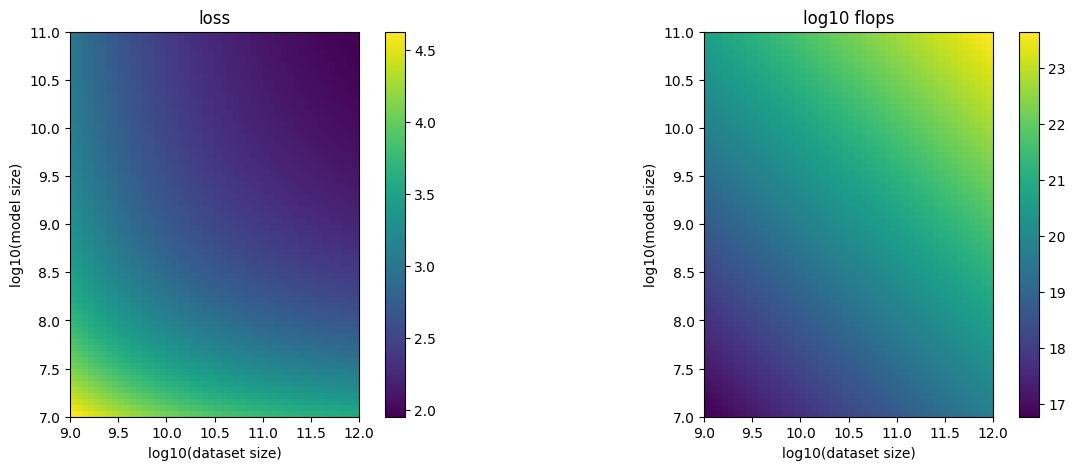

In [6]:
def L(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per Chinchilla paper.
    """
    E = 1.69 # entropy of natural language, limit of infinite model on infinite data
    A = 406.4
    B = 410.7
    alpha = 0.34
    beta = 0.28
    return A / (N ** alpha) + B / (D ** beta) + E

ns = 10 ** np.arange(7, 11, step=2**-4) # model sizes from 10M to 100B
ds = 10 ** np.arange(9, 12, step=2**-4) # dataset sizes from 1B to 1T
plt.figure(figsize=(15, 5))
# plot a heatmap of loss as a function of model size and dataset size
plt.subplot(121)
plt.imshow(np.array([[L(n, d) for d in ds] for n in ns]), extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()
# plot the compute for each point, which is a deterministic function: flops = 6*N*D
plt.subplot(122)
plt.imshow(np.log10(np.array([[6*n*d for d in ds] for n in ns])), extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

Ok so given any N,D we can estimate both: 1) the loss, and 2) the total flops. Now we want to solve the following problem: Given a specific budget of flops C, find: N_opt, D_opt = argmin_{FLOPs(N,D) = C} L(N, D). i.e. how big of a model should we train and for how many tokens?

best model size: 316.23M
best dataset size: 10.12B


Text(0, 0.5, 'loss')

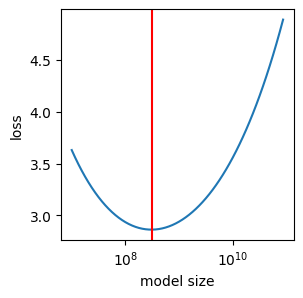

In [7]:
c = 1.92e19 # target compute budget (usually know this because we know how many GPU for how long go brrr)
# sweep model sizes from 10M to 100B
ns = 10 ** np.arange(7, 11, step=2**-4)
# using C = 6*N*D, solve for D that maintains the compute budget c
ds = c / (6 * ns)
# evaluate the loss in each case
losses = L(ns, ds)
# find the argmin
best = np.argmin(losses)
print(f"best model size: {ns[best]/1e6:.2f}M")
print(f"best dataset size: {ds[best]/1e9:.2f}B")
# plot the loss
plt.figure(figsize=(3,3))
plt.plot(ns, losses)
plt.xscale('log')
# plot a vertical bar at the best model size
plt.axvline(ns[best], color='red')
plt.xlabel('model size')
plt.ylabel('loss')

In the plot above, basically the models on the left of best are too small and trained for too long. The models on the right of best are way too large and trained for too little. The model at the red line is just right.

Now, the Chinchilla paper says that best model size is 400M params and 8B tokens, so this disagrees and there is some calculations problem. TODO figure out and fix...

compute budget 1.000000e+17: best model size: 29.43M, best dataset size: 0.57B
compute budget 1.778279e+17: best model size: 36.52M, best dataset size: 0.81B
compute budget 3.162278e+17: best model size: 48.70M, best dataset size: 1.08B
compute budget 5.623413e+17: best model size: 60.43M, best dataset size: 1.55B
compute budget 1.000000e+18: best model size: 80.58M, best dataset size: 2.07B
compute budget 1.778279e+18: best model size: 107.46M, best dataset size: 2.76B
compute budget 3.162278e+18: best model size: 133.35M, best dataset size: 3.95B
compute budget 5.623413e+18: best model size: 177.83M, best dataset size: 5.27B
compute budget 1.000000e+19: best model size: 220.67M, best dataset size: 7.55B
compute budget 1.778279e+19: best model size: 294.27M, best dataset size: 10.07B
compute budget 3.162278e+19: best model size: 392.42M, best dataset size: 13.43B
compute budget 5.623413e+19: best model size: 486.97M, best dataset size: 19.25B
compute budget 1.000000e+20: best model si

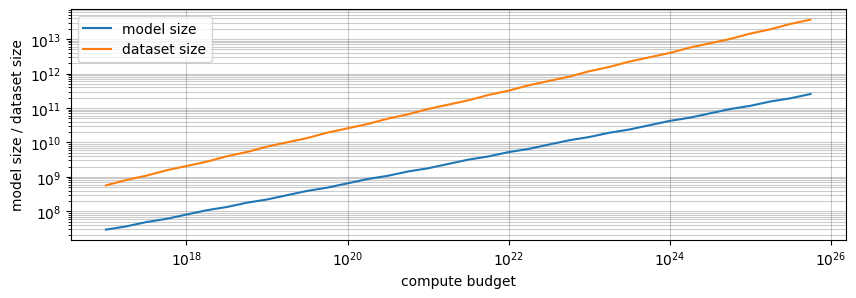

In [8]:
# sweep over compute budgets from 1e17 to 1e26
cs = 10 ** np.arange(17, 26, step=2**-2)
best_ns = []
best_ds = []
for c in cs:
    ns = 10 ** np.arange(7, 14, step=2**-5)
    ds = c / (6 * ns)
    losses = L(ns, ds)
    best = np.argmin(losses)
    best_ns.append(ns[best])
    best_ds.append(ds[best])
    print(f"compute budget {c:e}: best model size: {ns[best]/1e6:.2f}M, best dataset size: {ds[best]/1e9:.2f}B")

# plot both the model size and dataset size as a function of compute budget, on one plot
plt.figure(figsize=(10,3))
plt.plot(cs, best_ns, label='model size')
plt.plot(cs, best_ds, label='dataset size')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('compute budget')
plt.ylabel('model size / dataset size')
plt.grid(True, which="both", ls="-", color='k', alpha=0.2)
plt.legend()
